In [8]:
import sys
sys.path.insert(0, r"...")
import warnings
import pandas as pd
import numpy as np
from datetime import datetime
from data.dbengine import get_db_engine
from data.dbengine import get_db_klines
import backtest.backtest as bt
import backtest.backtest_analyse as ba
import CTA.CTA_signal as sg
import CTA.costant as cs
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

engine = get_db_engine('data', 'hbdata')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


market_data_folder_1h = cs.market_data_folder_1h

# start_index = 7  # 0, 24, 48, 72, 96; 23 means running at time 00:00
# plt.ioff()
# total_btc = 100
# number_portfolio = 9  # 12: 8h/12h/1d/5d, 9: 8h/12h/1d
# btc_per_portfolio = total_btc / number_portfolio





# # if consider coin_coef， Add BTC=5
# tsmom_coef_8h = 
# tsmom_coef_12h = 
# tsmom_coef_1d = 



# cross_ma_coef_8h = 
# cross_ma_coef_12h =
# cross_ma_coef_1d =



# rsi_coef_8h = 
# rsi_coef_12h = 
# rsi_coef_1d =





#####################################################
####################  #############################
#####################################################
data_price = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price = data_price[start_index:-1:8]

result_folder = cs.result_folder
para_df = pd.read_csv('{}/btc_based_params/new/params_8h.csv'.format(result_folder), index_col='coin')
coef_df = pd.read_csv('{}/btc_based_params/new/coin_coef.csv'.format(result_folder), index_col='coin')
# para_df = pd.read_pickle('{}/params_8h.pkl'.format(result_folder))
# coef_df = pd.read_pickle('{}/coin_coef.pkl'.format(result_folder))

######### for tsmom ###############
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    tsmom_window = para_df.loc[coin]['look_back_window']
    coef_temp = coef_df.loc[coin]['coef']
#     coef_temp = 1
    if tsmom_window == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.tsmom(data, tsmom_window), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * tsmom_coef_8h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * tsmom_coef_8h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_tsmom_8h = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    ma_short = para_df.loc[coin]['ma_short']
    ma_long = para_df.loc[coin]['ma_long']
    coef_temp = coef_df.loc[coin]['coef']
#     coef_temp = 1
    if ma_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.cross_ma(data, ma_short, ma_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * cross_ma_coef_8h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * cross_ma_coef_8h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_cross_ma_8h = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    rsi_short = para_df.loc[coin]['rsi_short']
    rsi_long = para_df.loc[coin]['rsi_long']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if rsi_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.RSI(data, rsi_short, rsi_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * rsi_coef_8h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * rsi_coef_8h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_rsi_8h = target_portfolio.copy()

##################################################
data_price_8h = data_price
target_portfolio_8h = target_portfolio_tsmom_8h + target_portfolio_cross_ma_8h + target_portfolio_rsi_8h

########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined

target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)

bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
bt_stats_all_8h = ba.statistics(bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(bt_result_8h, title="8h pnl - 1h data")


######################################################
##################################################
######################################################
start_index = 7 
plt.ioff()
data_price = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price = data_price[start_index:-1:12]

result_folder = cs.result_folder
para_df = pd.read_csv('{}/btc_based_params/new/params_12h.csv'.format(result_folder), index_col='coin')
coef_df = pd.read_csv('{}/btc_based_params/new/coin_coef.csv'.format(result_folder), index_col='coin')
# para_df = pd.read_pickle('{}/params_12h.pkl'.format(result_folder))
# coef_df = pd.read_pickle('{}/coin_coef.pkl'.format(result_folder))

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    tsmom_window = para_df.loc[coin]['look_back_window']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if tsmom_window == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.tsmom(data, tsmom_window), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * tsmom_coef_12h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * tsmom_coef_12h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_12h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_tsmom_12h = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    ma_short = para_df.loc[coin]['ma_short']
    ma_long = para_df.loc[coin]['ma_long']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if ma_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.cross_ma(data, ma_short, ma_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * cross_ma_coef_12h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * cross_ma_coef_12h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_12h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_cross_ma_12h = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    rsi_short = para_df.loc[coin]['rsi_short']
    rsi_long = para_df.loc[coin]['rsi_long']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if rsi_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.RSI(data, rsi_short, rsi_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * rsi_coef_12h
        pos[pos < 0] = -btc_per_portfolio * coef_temp * rsi_coef_12h
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_12h = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_rsi_12h = target_portfolio.copy()

##################################################
data_price_12h = data_price
target_portfolio_12h = target_portfolio_tsmom_12h + target_portfolio_cross_ma_12h + target_portfolio_rsi_12h

########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_12h_share = target_portfolio_12h / data_price_12h  # combined

target_portfolio_12h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_12h_share = pd.concat([target_portfolio_12h_share, temp_df], axis=1)
target_portfolio_12h_share.ffill(inplace=True)
target_portfolio_12h_share.fillna(0, inplace=True)

bt_result_12h = bt.backtest(data_price_1h,
                        target_portfolio_12h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
bt_stats_all_12h = ba.statistics(bt_result_12h, trading_bars_year=365 * 24)
print('12h signal, 1h Data:\n', bt_stats_all_12h, '\n')
ba.plot_pnl_portfolio(bt_result_12h, title="12h pnl - 1h data")


#####################################################
##################################################
#####################################################
start_index = 7
data_price = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price = data_price[start_index:-1:24]

result_folder = cs.result_folder
para_df = pd.read_csv('{}/btc_based_params/new/params_1d.csv'.format(result_folder), index_col='coin')
coef_df = pd.read_csv('{}/btc_based_params/new/coin_coef.csv'.format(result_folder), index_col='coin')
# para_df = pd.read_pickle('{}/params_1d.pkl'.format(result_folder))
# coef_df = pd.read_pickle('{}/coin_coef.pkl'.format(result_folder))
##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    tsmom_window = para_df.loc[coin]['look_back_window']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if tsmom_window == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.tsmom(data, tsmom_window), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * tsmom_coef_1d
        pos[pos < 0] = -btc_per_portfolio * coef_temp * tsmom_coef_1d
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_1d = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_tsmom_1d = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    ma_short = para_df.loc[coin]['ma_short']
    ma_long = para_df.loc[coin]['ma_long']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if ma_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.cross_ma(data, ma_short, ma_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * cross_ma_coef_1d
        pos[pos < 0] = -btc_per_portfolio * coef_temp * cross_ma_coef_1d
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_1d = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_cross_ma_1d = target_portfolio.copy()

##################################################
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    rsi_short = para_df.loc[coin]['rsi_short']
    rsi_long = para_df.loc[coin]['rsi_long']
    coef_temp = coef_df.loc[coin]['coef']
    # coef_temp = 1
    if rsi_short == 0:
        pos = pd.Series(0, index=data.index)
    else:
        pos = pd.Series(sg.RSI(data, rsi_short, rsi_long), index=data.index)
        pos[pos > 0] = btc_per_portfolio * coef_temp * rsi_coef_1d
        pos[pos < 0] = -btc_per_portfolio * coef_temp * rsi_coef_1d
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_1d = data_price
target_portfolio.columns = cs.coin_list
target_portfolio_rsi_1d = target_portfolio.copy()
##################################################
data_price_1d = data_price
target_portfolio_1d = target_portfolio_tsmom_1d + target_portfolio_cross_ma_1d + target_portfolio_rsi_1d

##################################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_1d_share = target_portfolio_1d / data_price_1d  # combined

target_portfolio_1d_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_1d_share = pd.concat([target_portfolio_1d_share, temp_df], axis=1)
target_portfolio_1d_share.ffill(inplace=True)
target_portfolio_1d_share.fillna(0, inplace=True)

bt_result_1d = bt.backtest(data_price_1h,
                        target_portfolio_1d_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
bt_stats_all_1d = ba.statistics(bt_result_1d, trading_bars_year=365 * 24)
print('1d signal, 1h Data:\n', bt_stats_all_1d, '\n')
ba.plot_pnl_portfolio(bt_result_1d, title="1d pnl - 1h data")


############################################################


# compute correlations
bt_result_pnl_total_combined = pd.DataFrame()
bt_result_pnl_total_combined['8h_pnl_total'] = bt_result_8h['pnl_total']
bt_result_pnl_total_combined['12h_pnl_total'] = bt_result_12h['pnl_total']
bt_result_pnl_total_combined['1d_pnl_total'] = bt_result_1d['pnl_total']
# bt_result_pnl_total_combined['5d_pnl_total'] = bt_result_5d['pnl_total']
bt_result_pnl_total_combined.corr()

############ Combined multiple portfolios ###################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
# target_portfolio_share = target_portfolio_8h_share + target_portfolio_12h_share + target_portfolio_1d_share + target_portfolio_5d_share
target_portfolio_share = target_portfolio_8h_share + target_portfolio_12h_share + target_portfolio_1d_share
# target_portfolio_share = target_portfolio_12h_share + target_portfolio_1d_share + target_portfolio_5d_share
# target_portfolio_share = target_portfolio_8h_share + target_portfolio_5d_share

bt_result = bt.backtest(data_price_1h,
                        target_portfolio_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
bt_stats_all = ba.statistics(bt_result, trading_bars_year=365 * 24)
print('combined portfolio, 1h Data:\n', bt_stats_all, '\n')


btc_based_data_price = data_price_1h
btc_based_data_price.columns = [f'{coin}_btc' for coin in cs.coin_list]
btc_based_target_portfolio_share = target_portfolio_share
btc_based_target_portfolio_share.columns = [f'{coin}_btc' for coin in cs.coin_list]

8h signal, 1h Data:
 index                 All       2018       2019      2020      2021
ret_pct           192.89%    227.24%    142.17%   227.32%   224.82%
ret_pct_maxbs     102.49%     136.6%      97.7%   141.05%   182.26%
volat_pct          47.31%     65.21%     41.85%    46.46%     93.2%
sharpe            4.07736     3.4848    3.39711   4.89288   2.41226
tvr              0.303212   0.216504   0.282886  0.337026  0.350243
tvr_rate            1.65%      2.24%      1.69%     1.57%     1.25%
rot_bps           133.788    116.036    96.0307   164.766   205.964
daily_pnl       0.0973582  0.0602937  0.0651979  0.133273   0.17313
daily_volat      0.456184   0.330552   0.366665  0.520385   1.37118
mdd               -5.5708    -1.9471    -3.2243   -4.9072   -5.5708
booksize          18.4232     9.6845    16.7384   21.3989   28.1078
abs_booksize      18.4232     9.6845    16.7384   21.3989   28.1078
max_booksize      34.6725    16.1109    24.3578   34.4864   34.6725
min_booksize            0  

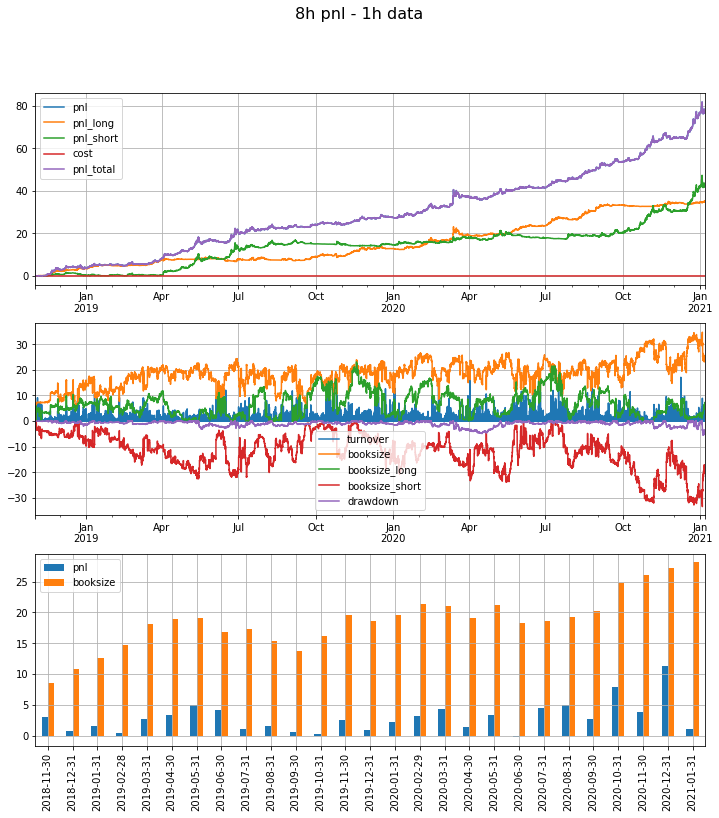

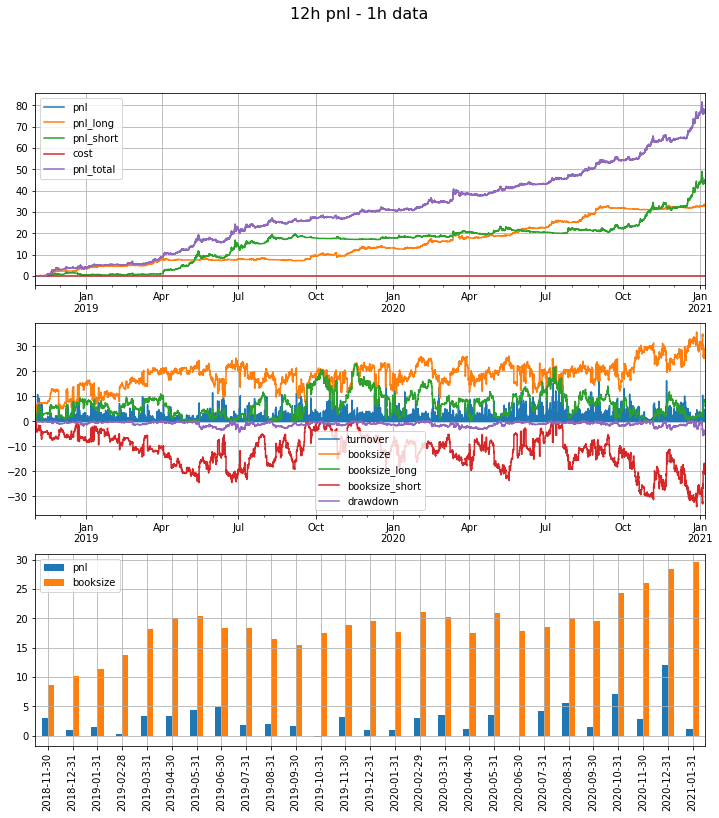

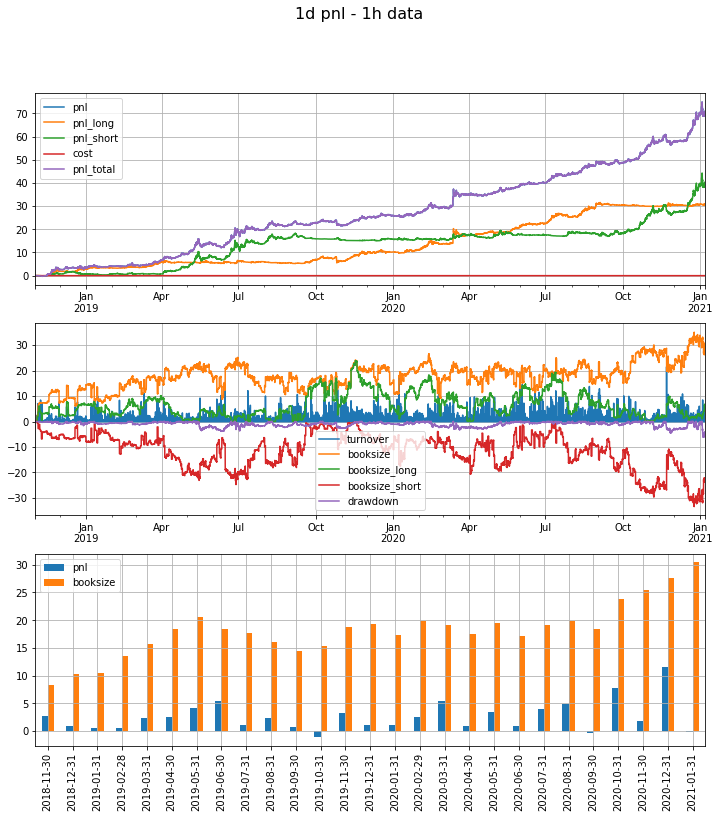

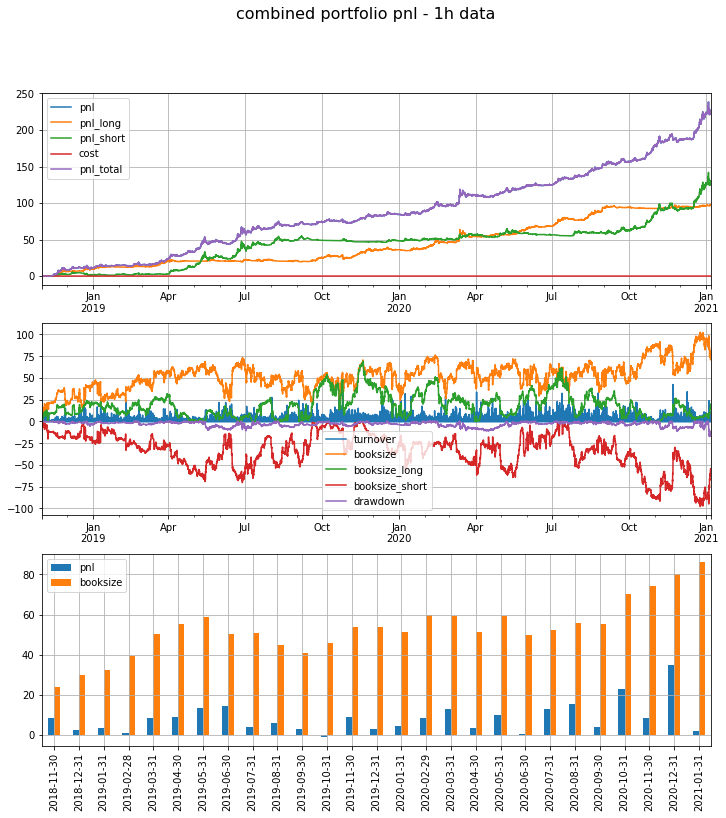

In [9]:
ba.plot_pnl_portfolio(bt_result, title="combined portfolio pnl - 1h data")
plt.show()